In [1]:
from datetime import date
from typing import List
from dataclasses import dataclass

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

[*********************100%%**********************]  5 of 5 completed


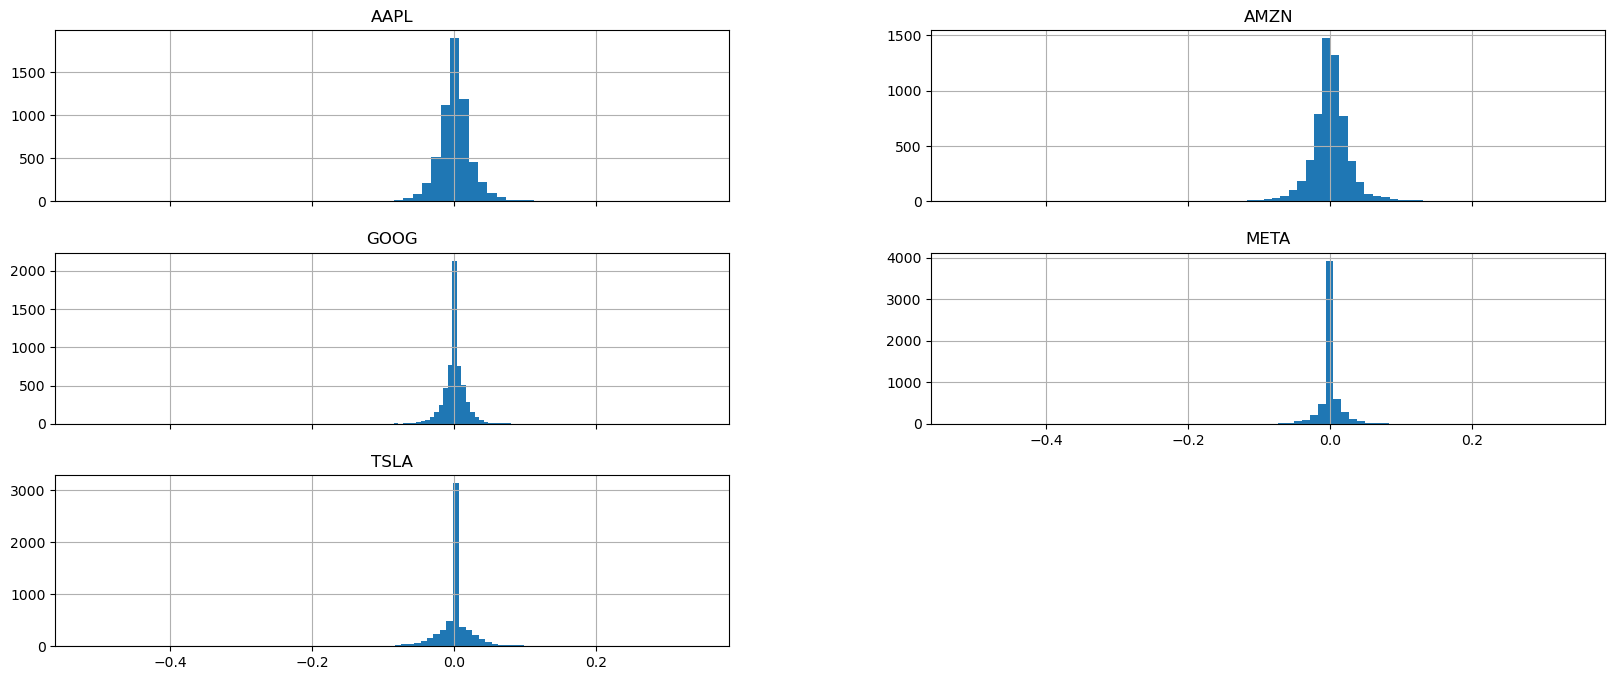

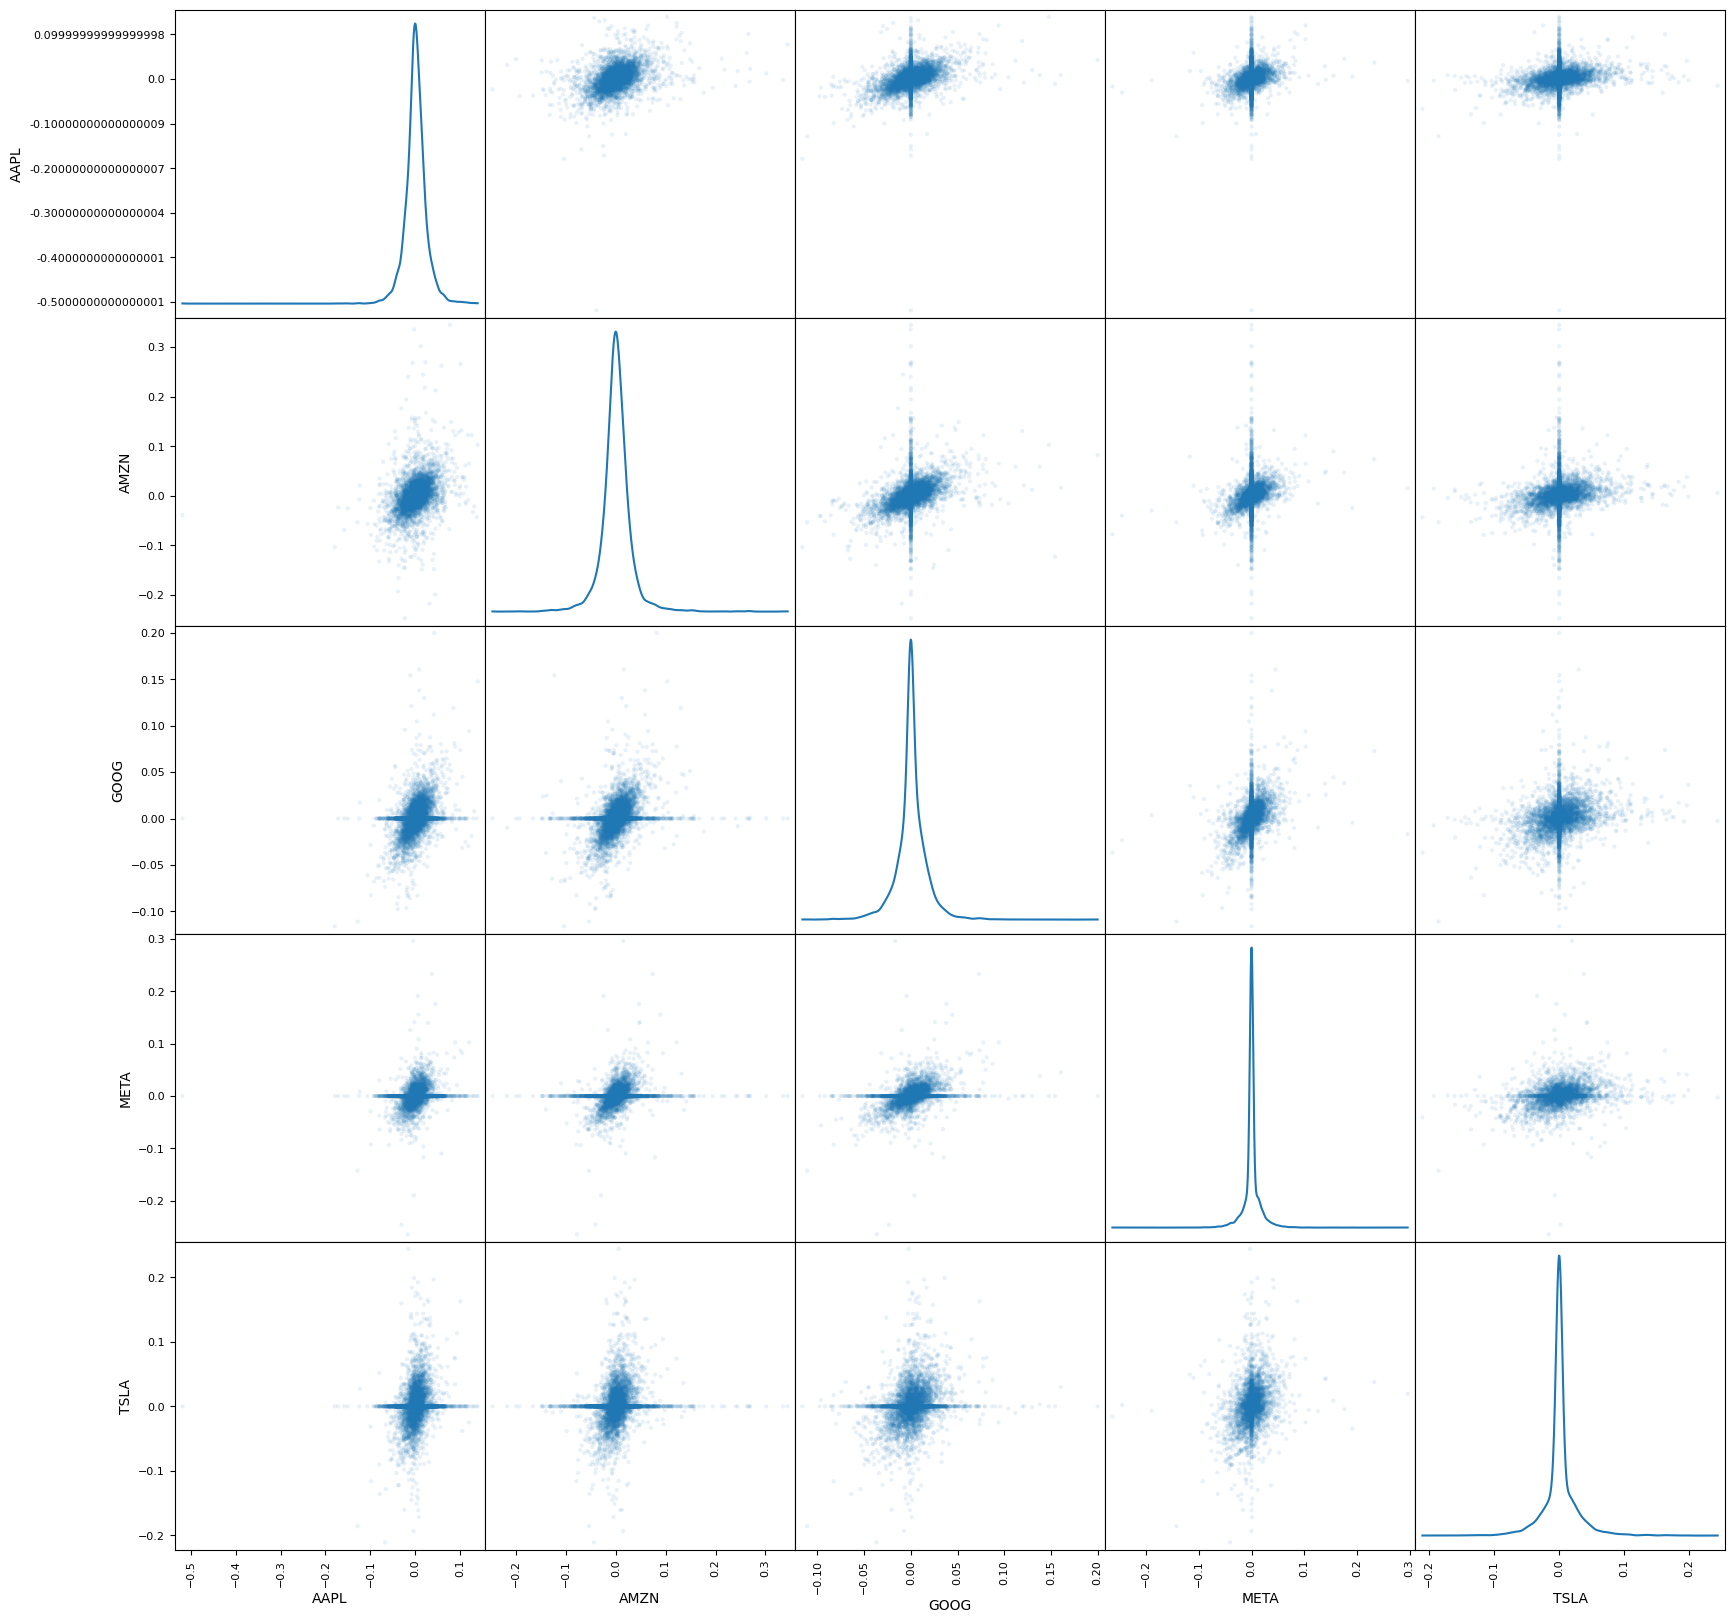

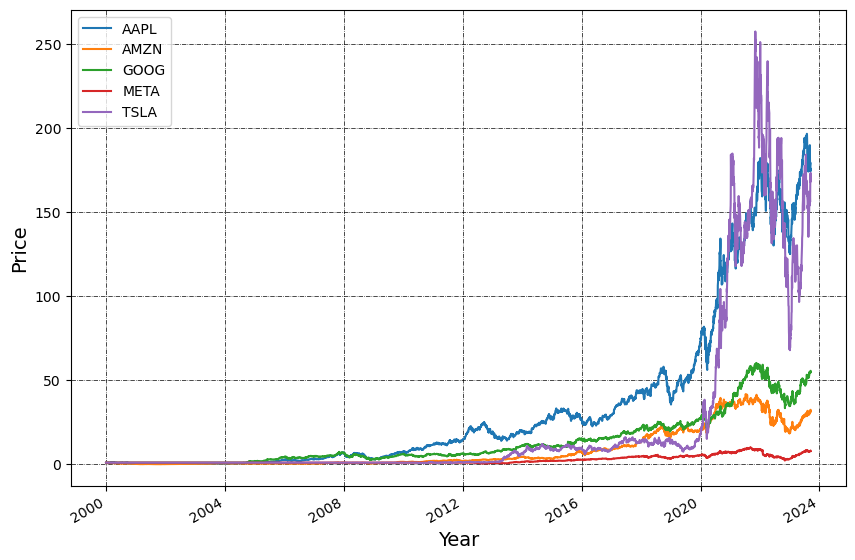

In [2]:
parameters = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
PARAMS_INFO = f'Available parameters: {"   ".join(parameters)}\n' \
              'Which parameter do you want to display?\n'

STOCK_INFO = f'Which stock do you want to display?\n' \
             'Press <Enter> to stop\n'


def select_parameter() -> str:
    parameter = ''
    while parameter not in parameters:
        parameter = input(PARAMS_INFO).strip().title()
    return parameter


def select_stocks() -> List[str]:
    tickers_list = []
    while True:
        stock_name = input(STOCK_INFO).strip().upper()
        if not stock_name and tickers_list:
            break
        elif stock_name:
            tickers_list.append(stock_name)
    return tickers_list


def fetch_data(parameter: str, tickers_list: List[str], start_date: date) -> pd.DataFrame:
    data = yf.download(tickers_list, start_date)[parameter]
    return data.fillna(0)


def set_start_date() -> date:
    date_ = input('Start date (yyyy-mm-dd): ').split('-')
    if int(date_[0]) < 2000:
        print('Missing information.Try again')
        return set_start_date()
    else:
        try:
            return date(*map(lambda x: int(x), date_))
        except ValueError:
            print('Invalid date or format.Try again')
            return set_start_date()


DAILY, MONTHLY, QUARTER = 'daily', 'monthly', 'quarter'
modes = (DAILY, MONTHLY, QUARTER)


def profitability(stocks: pd.DataFrame, mode: str = DAILY, log: bool = False) -> pd.DataFrame:
    """Represents the percentage change in the value of the stock in one trading day

    :param stocks : Downloaded data about the stock parameter
    :param mode: Displays what data to collect
    :param log: Allows you to better understand and explore changes over time
    :return: Profitability on the collected data
    """

    if mode not in modes:
        raise ValueError(f'Unknown mode - {mode}')

    data_modes = {
        DAILY: lambda: stocks,
        MONTHLY: lambda: stocks.resample('M').apply(lambda x: x[-1]),
        QUARTER: lambda: stocks.resample('4M').mean()
    }
    # preparing data
    data = data_modes[mode]().pct_change()
    data = data.replace([np.inf, -np.inf], 0)
    data = data.fillna(0)
    return np.log(data + 1) if log else data


def cumulative_profitability(prof: pd.DataFrame) -> pd.DataFrame:
    """Determines the value of investments after a certain period of time"""
    return (1 + prof).cumprod()


@dataclass
class Visualizator:
    """Renders profitability data"""
    profitability: pd.DataFrame

    def distribution(self) -> None:
        self.profitability.hist(bins=50, sharex=True, figsize=(20, 8))
        plt.show()

    def scatter(self) -> None:
        pd.plotting.scatter_matrix(self.profitability, diagonal='kde', alpha=0.1, figsize=(20, 20))
        plt.show()

    def cumulative(self) -> None:
        cumulative_profitability(self.profitability).plot(figsize=(10, 7))
        plt.legend()
        plt.ylabel('Price', fontsize=14)
        plt.xlabel('Year', fontsize=14)
        plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
        plt.show()


def main():
    # parameter = select_parameter()
    parameter = 'Close'
    # start_date = set_start_date()
    start_date = date(2000, 1, 1)
    # tickers_list = select_stocks()
    tickers_list = ['goog', 'aapl', 'meta', 'amzn', 'tsla']
    data = fetch_data(parameter, tickers_list, start_date)
    prof = profitability(stocks=data, mode=DAILY)

    v = Visualizator(prof)
    v.distribution()
    v.scatter()
    v.cumulative()


if __name__ == '__main__':
    main()